In [1]:
# ===============================
# Imports
# ===============================

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Machine Learning
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    StratifiedShuffleSplit,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance

# Metrics and evaluation
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from sklearn.calibration import CalibrationDisplay


In [2]:
# ===============================
# Project Constants
# ===============================

# Reproducibility
RANDOM_STATE = 420


# Target variable for classification
TARGET_COLUMN = 'Wildfire_bin'

# Columns to drop from dataset
DROP_IDS = ["runtime", "frame75_loc_id", "loc_id", "datetime"]
DROP_REDUNDANT_TIME = ["doy", "year", "month", "season"]
DROP_EXPERIMENTAL = ["weekday_sin","weekday_cos","hdw_score","weekday_weekend"]
DROP_UNUSED_ENG = ["vpd_times_wind", "wnd_slope", "dry_on_slope"]
DROP_MORE_UNUSED = ["dryness_score", "nlcd_wui_intensity"]
DROP_RT_FEATURES = ["fm100_mean_rt_50_59", "t_range_mean_rt_50_59"]
DROP_OTHER = ["pr_mean_rt_50_59","pet_mean_rt_50_59","pr_sum"]

DROP_COLUMNS = (
    DROP_IDS 
    + DROP_REDUNDANT_TIME
    + DROP_EXPERIMENTAL
    + DROP_UNUSED_ENG
    + DROP_MORE_UNUSED
    + DROP_RT_FEATURES
    + DROP_OTHER
    + [TARGET_COLUMN]
)


# Cross-validation settings
CV_FOLDS = 5

In [3]:
# ============================================================
# LOAD DATASETS
# ============================================================
train_df = pd.read_csv("../data/processed/updated_ds/dataset_with_terrain_new_train_2014_2021.csv")
test_df  = pd.read_csv("../data/processed/updated_ds/dataset_with_terrain_new_test_2022_2025.csv")

In [4]:
# ============================================================
# VALIDATION SPLIT FROM TRAINING SET
# ============================================================
VAL_SIZE = 0.2

train_df, val_df = train_test_split(
    train_df,
    test_size=VAL_SIZE,
    stratify=train_df["Wildfire_bin"],
    random_state=RANDOM_STATE,
)

In [5]:
# ============================================================
# Define Features / Target
# ============================================================

# Target vectors
y_train = train_df[TARGET_COLUMN]
y_val = val_df[TARGET_COLUMN]
y_test = test_df[TARGET_COLUMN]

# Feature matrices
# Remove identifiers, redundant features, and the target column
train_data = train_df.drop(columns=DROP_COLUMNS)
val_data = val_df.drop(columns=DROP_COLUMNS)
test_data = test_df.drop(columns=DROP_COLUMNS)

X_train = train_data
X_val = val_data
X_test = test_data

print("Data splits:")
print(f"  X_train: {X_train.shape}, positive fraction: {y_train.mean():.4f}")
print(f"  X_val:   {X_val.shape}, positive fraction: {y_val.mean():.4f}")
print(f"  X_test:  {X_test.shape}, positive fraction: {y_test.mean():.4f}")

Data splits:
  X_train: (85120, 34), positive fraction: 0.2026
  X_val:   (21281, 34), positive fraction: 0.2026
  X_test:  (19454, 34), positive fraction: 0.5810


In [7]:
# ===============================
# Pipeline & Hyperparameter Tuning
# ===============================

# Define Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("var_thresh", VarianceThreshold(threshold=1e-5)),
    ("logreg", LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=2000, random_state=RANDOM_STATE))
])

# Hyperparameter Grid
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1.0, 10.0],
    'logreg__penalty': ['l2']
}

# # Cross-Validation Strategy
# cv = StratifiedKFold(
#     n_splits=CV_FOLDS, 
#     shuffle=True, 
#     random_state=RANDOM_STATE
# )

# Stack train and validation together
X_cv = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_cv = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

n_train = len(X_train)
n_val   = len(X_val)

# Single-fold CV: train on training part, validate on validation part
cv_fold = [(np.arange(n_train), np.arange(n_train, n_train + n_val))]

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv_fold,
    n_jobs=-1,
    verbose=1,
    return_train_score=False
)

print("Starting GridSearch...")
grid.fit(X_cv, y_cv)    
print("Grid search complete.")


# Best Parameters and Score
print("Best params:", grid.best_params_)
print("Best roc_auc:", grid.best_score_)

Starting GridSearch...
Fitting 1 folds for each of 5 candidates, totalling 5 fits
Grid search complete.
Best params: {'logreg__C': 10.0, 'logreg__penalty': 'l2'}
Best roc_auc: 0.6356265446944934


In [8]:
# ===============================
# Evaluate Best Estimator on Validation Set
# ===============================

# Retrieve the best pipeline from GridSearch
best_model = grid.best_estimator_

# Predict probabilities for the positive class
val_probs = best_model.predict_proba(X_val)[:, 1]

# Default threshold metrics (0.5)
val_preds_05 = (val_probs >= 0.5).astype(int)

print("Validation set — default threshold 0.5")
print(classification_report(y_val, val_preds_05, digits=4))
print(f"ROC AUC: {roc_auc_score(y_val, val_probs):.4f}")
print(f"Average precision (PR AUC): {average_precision_score(y_val, val_probs):.4f}")

Validation set — default threshold 0.5
              precision    recall  f1-score   support

           0     0.8596    0.5374    0.6613     16970
           1     0.2644    0.6546    0.3767      4311

    accuracy                         0.5611     21281
   macro avg     0.5620    0.5960    0.5190     21281
weighted avg     0.7391    0.5611    0.6037     21281

ROC AUC: 0.6371
Average precision (PR AUC): 0.3027


In [9]:
# ===============================
# Threshold Selection on Validation Set
# ===============================

from sklearn.metrics import precision_score, recall_score

# Predict probabilities for the positive class on validation set
val_probs = best_model.predict_proba(X_val)[:, 1]

# Split validation into "tuning" and "selection" halves (same as your code)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=RANDOM_STATE)
split_idx = next(sss.split(X_val, y_val))
thresh_train_idx, thresh_sel_idx = split_idx

probs_tune = val_probs[thresh_train_idx]
y_tune = y_val.iloc[thresh_train_idx]
probs_sel = val_probs[thresh_sel_idx]
y_sel = y_val.iloc[thresh_sel_idx]

# Search thresholds for RECALL >= 0.90
thresholds = np.linspace(0.01, 0.99, 99)

best_thresh = 0.5
best_precision = -1
target_recall = 0.90

for t in thresholds:
    preds = (probs_tune >= t).astype(int)
    rec = recall_score(y_tune, preds)
    
    # Keep only thresholds achieving high recall
    if rec >= target_recall:
        prec = precision_score(y_tune, preds, zero_division=0)
        
        # pick threshold with best precision under recall constraint
        if prec > best_precision:
            best_precision = prec
            best_thresh = t

print(f"[TUNING] Best threshold = {best_thresh:.3f} achieving recall >= {target_recall}")
print(f"[TUNING] Precision at that threshold = {best_precision:.4f}")


[TUNING] Best threshold = 0.370 achieving recall >= 0.9
[TUNING] Precision at that threshold = 0.2311


[SELECTION] Metrics on selection split at threshold 0.370:
  Precision = 0.2317
  Recall    = 0.9142
  F1        = 0.3697
  Accuracy  = 0.3685
  ROC-AUC   = 0.6381


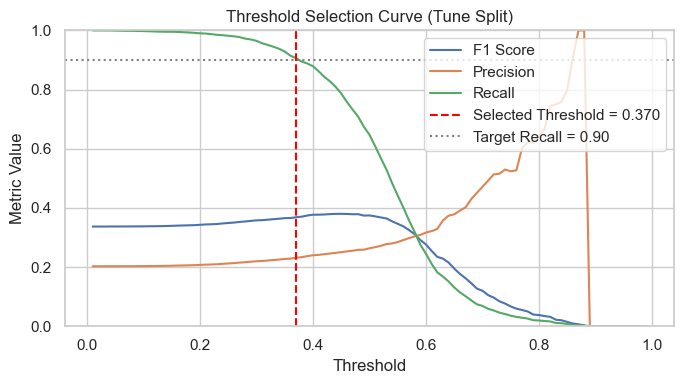

In [16]:
# ============================================================
# Evaluate this threshold on the *selection* split
# ============================================================

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

# Apply the best threshold to the selection subset
sel_preds = (probs_sel >= best_thresh).astype(int)

sel_precision = precision_score(y_sel, sel_preds, zero_division=0)
sel_recall    = recall_score(y_sel, sel_preds)
sel_f1        = f1_score(y_sel, sel_preds)
sel_acc       = accuracy_score(y_sel, sel_preds)

# ROC-AUC must use probabilities, not thresholded preds
sel_roc_auc   = roc_auc_score(y_sel, probs_sel)

print(f"[SELECTION] Metrics on selection split at threshold {best_thresh:.3f}:")
print(f"  Precision = {sel_precision:.4f}")
print(f"  Recall    = {sel_recall:.4f}")
print(f"  F1        = {sel_f1:.4f}")
print(f"  Accuracy  = {sel_acc:.4f}")
print(f"  ROC-AUC   = {sel_roc_auc:.4f}")

# ============================================================
# Compute Precision, Recall, F1 across thresholds (tune split)
# ============================================================

precision_list = []
recall_list = []
f1_list = []

for t in thresholds:
    preds = (probs_tune >= t).astype(int)
    precision_list.append(precision_score(y_tune, preds, zero_division=0))
    rec = recall_score(y_tune, preds)
    recall_list.append(rec)
    f1_list.append(f1_score(y_tune, preds))

# ============================================================
# Plot Threshold Selection Curve (tune split)
# ============================================================

plt.figure(figsize=(7, 4))
plt.plot(thresholds, f1_list, label="F1 Score")
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")

# vertical line: chosen threshold
plt.axvline(best_thresh, color="red", linestyle="--",
            label=f"Selected Threshold = {best_thresh:.3f}")

# horizontal line: target recall (for visual reference)
plt.axhline(target_recall, color="gray", linestyle=":", 
            label=f"Target Recall = {target_recall:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Selection Curve (Tune Split)")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Test set metrics (using selected threshold)
              precision    recall  f1-score   support

           0     0.6601    0.2840    0.3971      8152
           1     0.6340    0.8945    0.7420     11302

    accuracy                         0.6387     19454
   macro avg     0.6470    0.5893    0.5696     19454
weighted avg     0.6449    0.6387    0.5975     19454

ROC AUC: 0.6708
Average precision (PR AUC): 0.7266


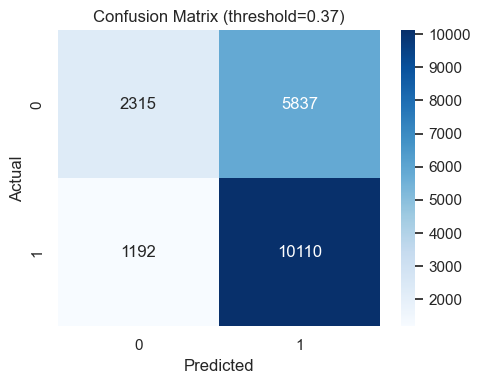

In [17]:
# ===============================
# Retrain Final Model on Train + Validation
# ===============================

# Combine training and validation sets
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

# Use the best pipeline from GridSearch
final_model = grid.best_estimator_
final_model.fit(X_train_val, y_train_val)

# Evaluate on test set
test_probs = final_model.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

print("Test set metrics (using selected threshold)")
print(classification_report(y_test, test_preds, digits=4))
print(f"ROC AUC: {roc_auc_score(y_test, test_probs):.4f}")
print(f"Average precision (PR AUC): {average_precision_score(y_test, test_probs):.4f}")

# --- Confusion matrix heatmap
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (threshold={best_thresh:.2f})')
plt.tight_layout()
plt.show()

# Save test metrics for record
metrics = {
    'roc_auc': roc_auc_score(y_test, test_probs),
    'avg_precision': average_precision_score(y_test, test_probs),
    'accuracy': accuracy_score(y_test, test_preds),
    'f1': f1_score(y_test, test_preds)
}

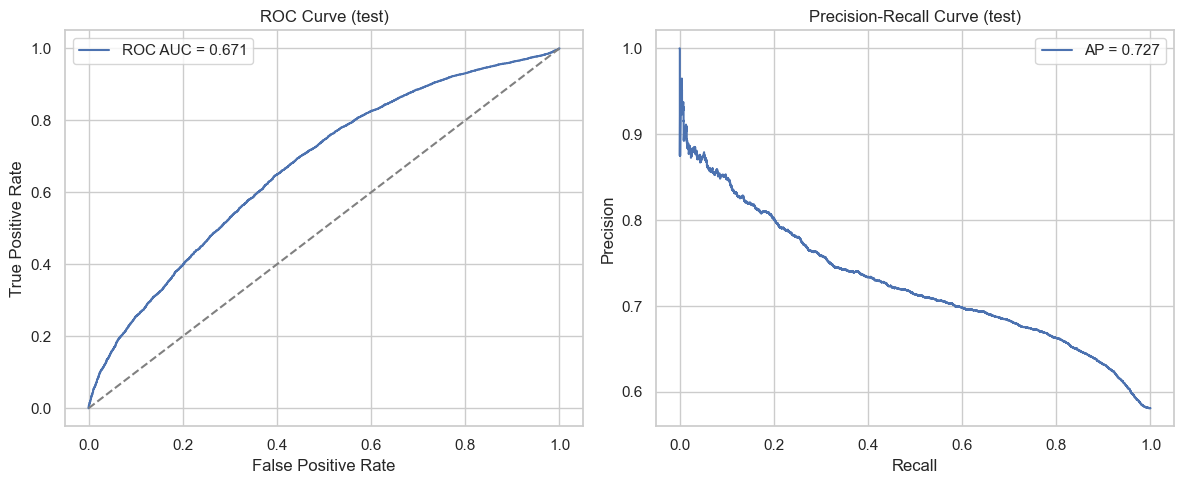

In [18]:
# ===============================
# ROC and Precision-Recall Curves on Test Set
# ===============================

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probs)

# Compute Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, test_probs)

# Plot ROC and PR Curves
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {metrics['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (test)')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {metrics['avg_precision']:.3f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (test)')
plt.legend()

plt.tight_layout()
plt.show()

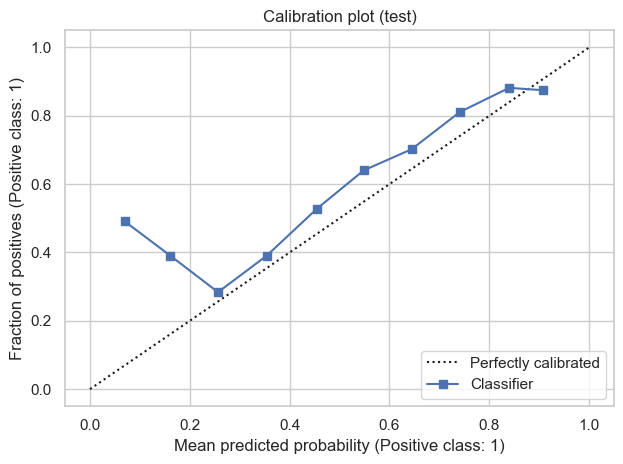

In [19]:
# ===============================
# Calibration Plot on Test Set
# ===============================

CalibrationDisplay.from_predictions(y_test, test_probs, n_bins=10)
plt.title('Calibration plot (test)')
plt.tight_layout()
plt.show()

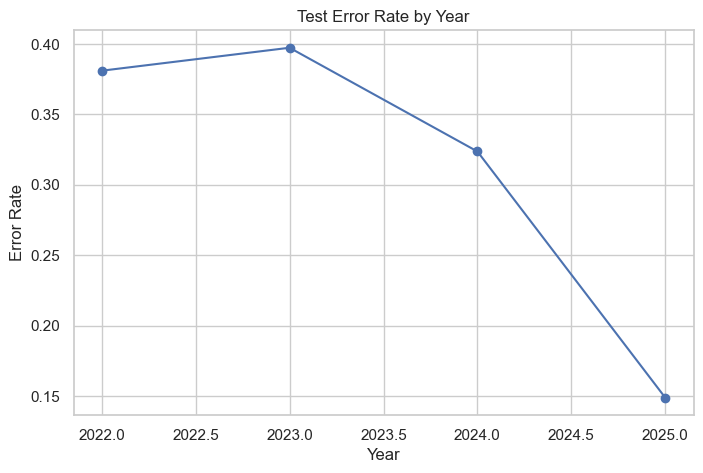

In [20]:
# ===============================
# Test Error Rate by Year
# ===============================

# Predict probabilities and binary labels using 0.5 threshold
probs = final_model.predict_proba(X_test)[:, 1]
test_df["pred"] = (probs >= 0.5).astype(int)

# Compute binary error
test_df["error"] = (test_df["pred"] != test_df["Wildfire_bin"]).astype(int)

# Convert to datetime if not already
test_df["datetime"] = pd.to_datetime(test_df["datetime"])
test_df["year"] = test_df["datetime"].dt.year

# Compute mean error rate per year
error_by_year = test_df.groupby("year")["error"].mean()

# Plot error rate over years
plt.figure(figsize=(8,5))
error_by_year.plot(marker="o")
plt.title("Test Error Rate by Year")
plt.ylabel("Error Rate")
plt.xlabel("Year")
plt.grid(True)
plt.show()

Top features by absolute coefficient:
              feature      coef  odds_ratio  abs_coef
  nlcd_human_presence  2.158256    8.656031  2.158256
 nlcd_fuel_continuity  1.347616    3.848241  1.347616
    erc_mean_rt_50_59 -1.126154    0.324278  1.126154
 fm1000_mean_rt_50_59 -0.806067    0.446611  0.806067
       nlcd_developed -0.753806    0.470572  0.753806
nlcd_water_ice_barren  0.731132    2.077430  0.731132
         nlcd_wetland  0.555139    1.742184  0.555139
   rmin_mean_rt_50_59 -0.462785    0.629528  0.462785
     bi_mean_rt_50_59  0.438735    1.550744  0.438735
          nlcd_forest  0.437102    1.548213  0.437102


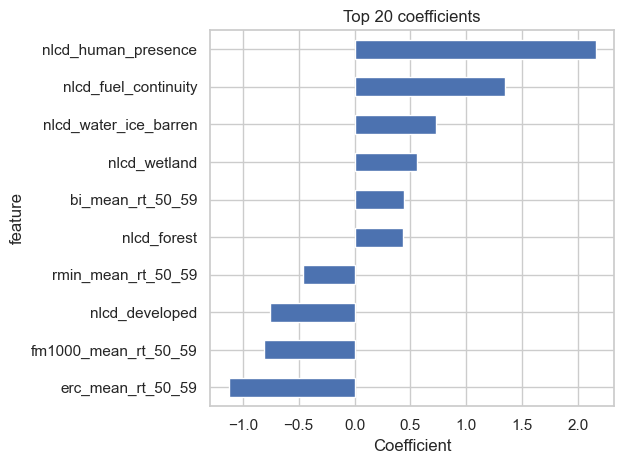

In [21]:
# ===============================
# Feature Coefficients & Odds Ratios
# ===============================

# Extract logistic regression step from pipeline
logreg = final_model.named_steps['logreg']

# Retrieve coefficients and feature names
coefs = logreg.coef_.ravel()
feat_names = X_train_val.columns

# Build a DataFrame for easy inspection
coef_df = pd.DataFrame({'feature': feat_names, 'coef': coefs})

# Compute odds ratios and absolute coefficient for sorting
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df['abs_coef'] = coef_df['coef'].abs()

# Sort by absolute impact
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Display Top Features by Absolute Coefficient
print("Top features by absolute coefficient:")
print(coef_df.head(10).to_string(index=False))

# Include direction of effect
coef_df['direction'] = np.where(coef_df['coef'] > 0, 'increase', 'decrease')

# Plot Top K Coefficients
topk = 10
top_abs = coef_df.head(topk).sort_values('coef')
top_abs.set_index('feature')['coef'].plot(kind='barh')
plt.title('Top 20 coefficients')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.show()